# CONNECT TO DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms, datasets
from torchsummary import summary
from torch.utils.data import DataLoader
import numpy as np
import os
from pathlib import Path
from typing import Dict, List, Tuple
from PIL import Image
import random
from timeit import default_timer as timer
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
# from going_modular.going_modular import data_setup, engine

In [ ]:
# Set the manual seeds (because dropout randomly drop the connection between layers)
torch.manual_seed(59)
torch.cuda.manual_seed(59)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
image_path = Path('data_working')
train_dir = image_path / "train"
test_dir = image_path / "test"
image_path, train_dir, test_dir

(PosixPath('data_working'),
 PosixPath('data_working/train'),
 PosixPath('data_working/test'))

In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224,)),
#     transforms.ToTensor(), #  Turn image values to between 0 & 1 
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], # A mean of [0.485, 0.456, 0.406] (across each colour channel)
#                          std=[0.229, 0.224, 0.225])
# ])

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=[-180, 180]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=[-180, 180]),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

transform_for_showing = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225])
    ])
}

In [ ]:
NUM_WORKERS = os.cpu_count()
def create_dataloaders(train_dir, test_dir, transform, batch_size, num_workers=NUM_WORKERS):
  # Use ImageFolder to create dataset
  train_data = datasets.ImageFolder(train_dir, transform=transform['train'])
  test_data = datasets.ImageFolder(test_dir, transform=transform['test'])

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
train_loader, test_loader, class_names = create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=transform, batch_size=16)
train_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f90d86a2c50>,
 ['level_1', 'level_2', 'level_3', 'level_4', 'level_5'])

In [ ]:
train_show_loader, test_show_loader, class_names = create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=transform_for_showing, batch_size=16)
train_show_loader, test_show_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f90d787d9c0>,
 ['level_1', 'level_2', 'level_3', 'level_4', 'level_5'])

In [ ]:
# Get a set of pretrained model weights
# DEFAULT = best available weights from pretraining on ImageNet
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

# TRANSFORM OF PRETRAINED WEIGHT

In [ ]:
# Get the transforms used to create pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#  Create training, testing DataLoaders and class names using auto_transforms
train_loader_autotransform, test_loader_autotransform, class_names = create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=32)
train_loader_autotransform, test_loader_autotransform, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f07544b4dc0>,
 ['level_1', 'level_2', 'level_3', 'level_4', 'level_5'])

# VISUALIZE IMAGE

In [ ]:
# images, labels = next(iter(train_loader))
images, labels = next(iter(train_show_loader))
images.shape, labels.shape, labels

(torch.Size([16, 3, 224, 224]),
 torch.Size([16]),
 tensor([2, 2, 2, 4, 3, 3, 1, 4, 3, 0, 0, 0, 2, 0, 4, 0]))

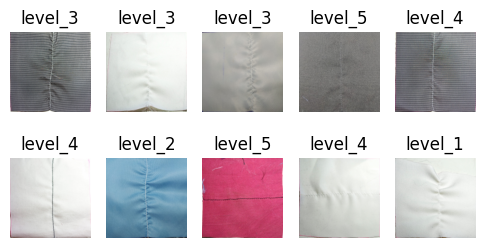

In [ ]:
# fig, axs = plt.subplots(5, 5, figsize=(15, 15))
# # plt.axis('off')
# for i in range(25):
#   axs[i].imshow(
#       np.transpose(images[i], (1, 2, 0))
#         # Can be written in images[i].permute(1, 2, 0).numpy()
#         # change the index of the shape (3 (0), 224 (1), 224 (2)) 
#         # then become (224 (1), 224 (2), 3 (0))
#   )
#   # axs[i].title.set_text(labels[i])
fig = plt.figure(figsize=(6, 3))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(np.transpose(images[i], (1, 2, 0)))
  plt.title(class_names[labels[i]])
  plt.axis('off')
plt.savefig('seamImageList.png', bbox_inches='tight') 

# TRAINING FUNCTION DEFINITION

In [ ]:
def train_step(model, train_loader, loss_fn, optimizer, device) -> Tuple[float, float]:
  '''
    Train a model for single epoch
  '''
  # Put model in train mode
  model.train()
  
  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (input, label) in enumerate(train_loader):
    # Send data to target device
    input, label = input.to(device), label.to(device)

    # Forward pass
    output = model(input)

    # Calculate and accumulate loss
    loss = loss_fn(output, label)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    output_class = torch.argmax(
        torch.softmax(output, dim=1),
        dim=1
    )
    train_acc += (output_class == label).sum().item()/len(output)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)
  return train_loss, train_acc

def test_step(model, test_loader, loss_fn, device) -> Tuple[float, float]:
  '''
    Test model for single epoch
  '''
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (input, label) in enumerate(test_loader):
      # Send data to target device
      input, label = input.to(device), label.to(device)

      # Forward pass
      test_pred_logits = model(input)

      # Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, label)
      test_loss += loss.item()

      # Calculate and accumuate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == label).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    return test_loss, test_acc

def train(model, train_loader, test_loader, optimizer, loss_fn, epochs, device, save_path) -> Dict[str, str]:
    '''
      Train and test model
    '''
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in range(1, epochs + 1):
      train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
      test_loss, test_acc = test_step(model, test_loader, loss_fn, device)

      # Print out what's happening
      print(
          f"Epoch: {epoch} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

      # Save the model
      torch.save(model.state_dict(), save_path)

    # Return the filled results at the end of the epochs
    return results

def process_training(model, train_loader, test_loader, optimizer, loss_fn, epochs, device, save_path):
  # Start the timer
  start_time = timer()

  # Setup training and save the results
  results = train(model, train_loader, test_loader, optimizer, loss_fn, epochs, device=device, save_path=save_path)

  # End the timer adn print out how long it took
  end_time = timer()
  print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")
  return results

In [ ]:
def test_process(test_loader, model, loss_fn, device):
  test_loss = 0.
  correct = 0.
  total = 0.

  preds = []
  labels = []
  model.to(device)
  model.eval()

  for batch_idx, (data, label) in enumerate(test_loader):
    data, label = data.to(device), label.to(device)
    output = model(data)

    loss = loss_fn(output, label)
    test_loss += loss.item()
    pred = output.data.max(1, keepdim=True)[1]
    preds.append(pred)
    labels.append(label)
    correct += np.sum(np.squeeze(pred.eq(label.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

  print('Test Loss: {:.6f}\n'.format(test_loss))
  print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
  return preds, labels

def evaluate_process(test_loader, model, loss_fn, device):
  preds, labels = test_process(test_loader, model, loss_fn, device)
  # print(preds[0].shape, labels[0].shape)
  predictions = []
  for pred in preds:
    for x in np.array(pred.detach().cpu()):
      predictions.append(x[0])

  ground_truth = []
  for truth in labels:
    for x in np.array(truth.detach().cpu()):
      ground_truth.append(x)
  
  # print(predictions)
  # print(ground_truth)
  # print(precision_recall_fscore_support(ground_truth, predictions))
  # precision = precision_score(ground_truth, predictions, average='macro')
  # recall = recall_score(ground_truth, predictions, average='macro')
  # f1 = f1_score(ground_truth, predictions, average='macro')
  precision = np.mean(precision_recall_fscore_support(ground_truth, predictions)[0])
  recall = np.mean(precision_recall_fscore_support(ground_truth, predictions)[1])
  f1 = np.mean(precision_recall_fscore_support(ground_truth, predictions)[2])
  print(f'Precision: {precision}, Recall: {recall}, F1-score: {f1}')


# LOAD MODELS

In [ ]:
effi_b0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
resnet50 = torchvision.models.resnet50(pretrained=True).to(device)
mobilenet = torchvision.models.mobilenet_v2(pretrained=True).to(device)
vgg19 = torchvision.models.vgg19(pretrained=True).to(device)
vgg16 = torchvision.models.vgg16(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 61.4MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weight

In [ ]:
# Get the length of class_names (one ouput unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device of EfficientnetB0
effi_b0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=output_shape,
        bias=True
    )
).to(device)
# Change the fc layer of ResNet50
resnet50.fc = torch.nn.Linear(in_features=2048, out_features=output_shape, bias=True).to(device)
# Change the classifier layer of MobileNetV2
mobilenet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)
# Change the classifier layer of vgg19 and vgg16
vgg16.classifier[6] = torch.nn.Linear(in_features=4096, out_features=output_shape, bias=True).to(device)
vgg19.classifier[6] = torch.nn.Linear(in_features=4096, out_features=output_shape, bias=True).to(device)

In [ ]:
def load_model(model, model_path):
  if(os.path.isfile(model_path)):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print('Load trained model successfully!')
  else:
    print('No model found')

In [ ]:
# Load models if any
load_model(effi_b0, './savedmodel/effi_b0.pt')
load_model(resnet50, './savedmodel/resnet50.pt')
load_model(mobilenet, './savedmodel/mobilenet.pt')
load_model(vgg19, './savedmodel/vgg19.pt')
load_model(vgg16, './savedmodel/vgg16.pt')

Load trained model successfully!
Load trained model successfully!
Load trained model successfully!
Load trained model successfully!
Load trained model successfully!


In [ ]:
# Get optimizer
effi_optim = torch.optim.Adam(effi_b0.parameters(), lr=0.001)
resnet50_optim = torch.optim.Adam(resnet50.parameters(), lr=0.001)
mobilenet_optim = torch.optim.Adam(mobilenet.parameters(), lr=0.001)
vgg16_optim = torch.optim.Adam(vgg16.parameters(), lr=0.001)
vgg19_optim = torch.optim.Adam(vgg19.parameters(), lr=0.001)
# loss function
loss_fn = nn.CrossEntropyLoss()

# TRAINING ZONE (MANY MODELS)

In [ ]:
results_effi = process_training(effi_b0, train_loader, test_loader, effi_optim, loss_fn, 50, device, './savedmodel/effi_b0.pt')

Epoch: 1 | train_loss: 0.4646 | train_acc: 0.8353 | test_loss: 1.2411 | test_acc: 0.6765
Epoch: 2 | train_loss: 0.3741 | train_acc: 0.8546 | test_loss: 1.0127 | test_acc: 0.6838
Epoch: 3 | train_loss: 0.3319 | train_acc: 0.8738 | test_loss: 1.0861 | test_acc: 0.6630
Epoch: 4 | train_loss: 0.2942 | train_acc: 0.8786 | test_loss: 0.9099 | test_acc: 0.7132
Epoch: 5 | train_loss: 0.2470 | train_acc: 0.9111 | test_loss: 1.0713 | test_acc: 0.7243
Epoch: 6 | train_loss: 0.3195 | train_acc: 0.8750 | test_loss: 1.1415 | test_acc: 0.6998
Epoch: 7 | train_loss: 0.3754 | train_acc: 0.8401 | test_loss: 1.2280 | test_acc: 0.6544
Epoch: 8 | train_loss: 0.3456 | train_acc: 0.8726 | test_loss: 1.1292 | test_acc: 0.7365
Epoch: 9 | train_loss: 0.3534 | train_acc: 0.8582 | test_loss: 1.0865 | test_acc: 0.6654
Epoch: 10 | train_loss: 0.2768 | train_acc: 0.9002 | test_loss: 1.0893 | test_acc: 0.6887
Epoch: 11 | train_loss: 0.2888 | train_acc: 0.9087 | test_loss: 1.2169 | test_acc: 0.6949
Epoch: 12 | train_l

In [ ]:
results_resnet50 = process_training(resnet50, train_loader, test_loader, resnet50_optim, loss_fn, 50, device, './savedmodel/resnet50.pt')

Epoch: 1 | train_loss: 0.7756 | train_acc: 0.6659 | test_loss: 2.9771 | test_acc: 0.5539
Epoch: 2 | train_loss: 0.7731 | train_acc: 0.6659 | test_loss: 0.9152 | test_acc: 0.6471
Epoch: 3 | train_loss: 0.8146 | train_acc: 0.6611 | test_loss: 0.8623 | test_acc: 0.5735
Epoch: 4 | train_loss: 0.7680 | train_acc: 0.7031 | test_loss: 0.8362 | test_acc: 0.7047
Epoch: 5 | train_loss: 0.7704 | train_acc: 0.6815 | test_loss: 0.7827 | test_acc: 0.6752
Epoch: 6 | train_loss: 0.7570 | train_acc: 0.6875 | test_loss: 0.7817 | test_acc: 0.6740
Epoch: 7 | train_loss: 0.7967 | train_acc: 0.6623 | test_loss: 0.9741 | test_acc: 0.6471
Epoch: 8 | train_loss: 0.7404 | train_acc: 0.6995 | test_loss: 0.7882 | test_acc: 0.6985
Epoch: 9 | train_loss: 0.7342 | train_acc: 0.6791 | test_loss: 1.1416 | test_acc: 0.5074
Epoch: 10 | train_loss: 0.8127 | train_acc: 0.6635 | test_loss: 0.9354 | test_acc: 0.6409
Epoch: 11 | train_loss: 0.7572 | train_acc: 0.6863 | test_loss: 1.0389 | test_acc: 0.5257
Epoch: 12 | train_l

In [ ]:
results_mobilnet = process_training(mobilenet, train_loader, test_loader, mobilenet_optim, loss_fn, 50, device, './savedmodel/mobilenet.pt')

Epoch: 1 | train_loss: 0.6417 | train_acc: 0.7500 | test_loss: 1.0540 | test_acc: 0.6581
Epoch: 2 | train_loss: 0.6108 | train_acc: 0.7632 | test_loss: 0.6699 | test_acc: 0.7475
Epoch: 3 | train_loss: 0.6306 | train_acc: 0.7524 | test_loss: 0.9593 | test_acc: 0.6654
Epoch: 4 | train_loss: 0.5704 | train_acc: 0.7632 | test_loss: 1.0303 | test_acc: 0.6949
Epoch: 5 | train_loss: 0.6068 | train_acc: 0.7716 | test_loss: 0.8398 | test_acc: 0.7365
Epoch: 6 | train_loss: 0.5965 | train_acc: 0.7656 | test_loss: 0.8519 | test_acc: 0.6765
Epoch: 7 | train_loss: 0.5730 | train_acc: 0.7584 | test_loss: 1.0274 | test_acc: 0.5797
Epoch: 8 | train_loss: 0.5931 | train_acc: 0.7596 | test_loss: 0.9151 | test_acc: 0.6667
Epoch: 9 | train_loss: 0.5775 | train_acc: 0.7704 | test_loss: 0.9516 | test_acc: 0.6875
Epoch: 10 | train_loss: 0.5133 | train_acc: 0.8017 | test_loss: 0.7972 | test_acc: 0.6740
Epoch: 11 | train_loss: 0.5761 | train_acc: 0.7692 | test_loss: 0.7079 | test_acc: 0.7292
Epoch: 12 | train_l

In [ ]:
results_vgg19 = process_training(vgg19, train_loader, test_loader, vgg19_optim, loss_fn, 50, device, './savedmodel/vgg19.pt')

Epoch: 1 | train_loss: 1.6130 | train_acc: 0.2212 | test_loss: 1.6181 | test_acc: 0.2022
Epoch: 2 | train_loss: 1.6160 | train_acc: 0.2079 | test_loss: 1.6122 | test_acc: 0.2206
Epoch: 3 | train_loss: 1.6087 | train_acc: 0.2139 | test_loss: 1.6140 | test_acc: 0.2206
Epoch: 4 | train_loss: 1.6177 | train_acc: 0.2200 | test_loss: 1.6077 | test_acc: 0.2206
Epoch: 5 | train_loss: 1.6136 | train_acc: 0.2007 | test_loss: 1.6133 | test_acc: 0.2206
Epoch: 6 | train_loss: 1.6110 | train_acc: 0.2139 | test_loss: 1.6116 | test_acc: 0.2206
Epoch: 7 | train_loss: 1.6085 | train_acc: 0.2151 | test_loss: 1.6166 | test_acc: 0.2206
Epoch: 8 | train_loss: 1.6122 | train_acc: 0.2296 | test_loss: 1.6168 | test_acc: 0.2206
Epoch: 9 | train_loss: 1.6135 | train_acc: 0.2079 | test_loss: 1.6123 | test_acc: 0.2022
Epoch: 10 | train_loss: 1.6097 | train_acc: 0.2200 | test_loss: 1.6133 | test_acc: 0.2206
Epoch: 11 | train_loss: 1.6074 | train_acc: 0.2260 | test_loss: 1.6146 | test_acc: 0.2022
Epoch: 12 | train_l

In [ ]:
results_vgg16 = process_training(vgg16, train_loader, test_loader, vgg16_optim, loss_fn, 50, device, './savedmodel/vgg16.pt')

Epoch: 1 | train_loss: 1.6127 | train_acc: 0.2188 | test_loss: 1.6119 | test_acc: 0.2206
Epoch: 2 | train_loss: 1.6087 | train_acc: 0.2344 | test_loss: 1.6143 | test_acc: 0.2206
Epoch: 3 | train_loss: 1.6086 | train_acc: 0.2428 | test_loss: 1.6158 | test_acc: 0.2206
Epoch: 4 | train_loss: 1.6079 | train_acc: 0.2296 | test_loss: 1.6191 | test_acc: 0.2206
Epoch: 5 | train_loss: 1.6209 | train_acc: 0.2091 | test_loss: 1.6126 | test_acc: 0.2206
Epoch: 6 | train_loss: 1.6104 | train_acc: 0.2139 | test_loss: 1.6166 | test_acc: 0.2206
Epoch: 7 | train_loss: 1.6105 | train_acc: 0.2272 | test_loss: 1.6137 | test_acc: 0.2022
Epoch: 8 | train_loss: 1.6064 | train_acc: 0.2248 | test_loss: 1.6184 | test_acc: 0.2206
Epoch: 9 | train_loss: 1.6121 | train_acc: 0.2175 | test_loss: 1.6137 | test_acc: 0.2206
Epoch: 10 | train_loss: 1.6090 | train_acc: 0.2356 | test_loss: 1.6109 | test_acc: 0.2206
Epoch: 11 | train_loss: 1.6130 | train_acc: 0.2236 | test_loss: 1.6146 | test_acc: 0.2022
Epoch: 12 | train_l

# EVALUATE MODELS

In [ ]:
evaluate_process(test_loader, effi_b0, loss_fn, device)

Test Loss: 26.309632


Test Accuracy: 67% (175/259)
Precision: 0.7000552710308808, Recall: 0.6829244040072588, F1-score: 0.6802936953681761


In [ ]:
evaluate_process(test_loader, resnet50, loss_fn, device)

Test Loss: 13.016251


Test Accuracy: 74% (194/259)
Precision: 0.7566169070520311, Recall: 0.7526565076524061, F1-score: 0.7447347555723471


In [ ]:
evaluate_process(test_loader, mobilenet, loss_fn, device)

Test Loss: 17.100428


Test Accuracy: 76% (197/259)
Precision: 0.7702685546714043, Recall: 0.7581744433672244, F1-score: 0.7619256355577713


In [ ]:
evaluate_process(test_loader, vgg19, loss_fn, device)

Test Loss: 27.346804


Test Accuracy: 23% (60/259)
Precision: 0.04633204633204634, Recall: 0.2, F1-score: 0.07523510971786834


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
evaluate_process(test_loader, vgg16, loss_fn, device)

Test Loss: 27.401030


Test Accuracy: 23% (60/259)
Precision: 0.04633204633204634, Recall: 0.2, F1-score: 0.07523510971786834


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LOAD MODEL (EFFICIENTB0 ONLY)

In [ ]:
ls

data/  data_cloned/  data_working/  eff_b0_18_05_2023_1505.pt  savedmodel/


In [ ]:
# os.path.isfile('eff_b0_18_05_2023_1505.pt')

True

In [ ]:
# Setup model with pretrained WEIGHTS (new method instead of using pretrained=True)
effi_b0 = torchvision.models.efficientnet_b0(weights=weights).to(device)
# effi_b0

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 58.7MB/s]


In [ ]:
# summary(model=effi_b0, input_size=(3, 224, 224))

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in effi_b0.features.parameters():
#   param.requires_grad = False

In [ ]:
# Get the length of class_names (one ouput unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
effi_b0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=output_shape,
        bias=True
    )
).to(device)

In [ ]:
summary(effi_b0, input_size=(3, 224, 224))

In [ ]:
# Load model if any (Must load after updating the classifier layer or else it won't work as 
# the downloaded model is different at the classifier layer)
if(os.path.isfile('eff_b0_18_05_2023_1505.pt')):
  effi_b0.load_state_dict(torch.load('eff_b0_18_05_2023_1505.pt', map_location=device))
  effi_b0.eval()
  print('Load trained model successfully!')
else:
  print('Load trained model failed')

Load trained model successfully!


In [ ]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effi_b0.parameters(), lr=0.001)

# TRAINING ZONE (EFFICIENTB0 ONLY)

In [ ]:
# Best result 0.7639
results = process_training(effi_b0, train_loader, test_loader, optimizer, loss_fn, 50, device, 'eff_b0_18_05_2023_1505.pt')

Epoch: 1 | train_loss: 1.3423 | train_acc: 0.5144 | test_loss: 1.3114 | test_acc: 0.5278
Epoch: 2 | train_loss: 1.0661 | train_acc: 0.6058 | test_loss: 1.0765 | test_acc: 0.5926
Epoch: 3 | train_loss: 0.9364 | train_acc: 0.6094 | test_loss: 0.9084 | test_acc: 0.6620
Epoch: 4 | train_loss: 0.7806 | train_acc: 0.6755 | test_loss: 0.8761 | test_acc: 0.6470
Epoch: 5 | train_loss: 0.6645 | train_acc: 0.7296 | test_loss: 0.7524 | test_acc: 0.6956
Epoch: 6 | train_loss: 0.6727 | train_acc: 0.7091 | test_loss: 1.0028 | test_acc: 0.6042
Epoch: 7 | train_loss: 0.6551 | train_acc: 0.7248 | test_loss: 0.7674 | test_acc: 0.6898
Epoch: 8 | train_loss: 0.5955 | train_acc: 0.7620 | test_loss: 0.8498 | test_acc: 0.6146
Epoch: 9 | train_loss: 0.6191 | train_acc: 0.7380 | test_loss: 1.7187 | test_acc: 0.6030
Epoch: 10 | train_loss: 0.5234 | train_acc: 0.7704 | test_loss: 0.9687 | test_acc: 0.6863
Epoch: 11 | train_loss: 0.4922 | train_acc: 0.8173 | test_loss: 2.2462 | test_acc: 0.6354
Epoch: 12 | train_l

In [ ]:
# Best result 73.73%
results = process_training(effi_b0, train_loader, test_loader, optimizer, loss_fn, 50, device, 'eff_b0_18_05_2023_1505.pt')

Epoch: 1 | train_loss: 0.3008 | train_acc: 0.8966 | test_loss: 1.3408 | test_acc: 0.6481
Epoch: 2 | train_loss: 0.2624 | train_acc: 0.9002 | test_loss: 1.6840 | test_acc: 0.6551
Epoch: 3 | train_loss: 0.2042 | train_acc: 0.9159 | test_loss: 1.6800 | test_acc: 0.6528
Epoch: 4 | train_loss: 0.2453 | train_acc: 0.9099 | test_loss: 1.6246 | test_acc: 0.6655
Epoch: 5 | train_loss: 0.1757 | train_acc: 0.9399 | test_loss: 1.3183 | test_acc: 0.6829
Epoch: 6 | train_loss: 0.2395 | train_acc: 0.9075 | test_loss: 1.5674 | test_acc: 0.6285
Epoch: 7 | train_loss: 0.1553 | train_acc: 0.9375 | test_loss: 1.2688 | test_acc: 0.7199
Epoch: 8 | train_loss: 0.1867 | train_acc: 0.9327 | test_loss: 1.4844 | test_acc: 0.6319
Epoch: 9 | train_loss: 0.2165 | train_acc: 0.9207 | test_loss: 1.3571 | test_acc: 0.6620
Epoch: 10 | train_loss: 0.1698 | train_acc: 0.9411 | test_loss: 1.5472 | test_acc: 0.6840
Epoch: 11 | train_loss: 0.1728 | train_acc: 0.9399 | test_loss: 2.2045 | test_acc: 0.6285
Epoch: 12 | train_l

In [ ]:
results = process_training(effi_b0, train_loader, test_loader, optimizer, loss_fn, 50, device, 'eff_b0_18_05_2023_1505.pt')

Epoch: 1 | train_loss: 0.2992 | train_acc: 0.8954 | test_loss: 1.3897 | test_acc: 0.7096
Epoch: 2 | train_loss: 0.1800 | train_acc: 0.9363 | test_loss: 1.4571 | test_acc: 0.6740
Epoch: 3 | train_loss: 0.1768 | train_acc: 0.9327 | test_loss: 1.4922 | test_acc: 0.6949
Epoch: 4 | train_loss: 0.1958 | train_acc: 0.9279 | test_loss: 1.4964 | test_acc: 0.6691
Epoch: 5 | train_loss: 0.2451 | train_acc: 0.9159 | test_loss: 1.6549 | test_acc: 0.6213
Epoch: 6 | train_loss: 0.2303 | train_acc: 0.9050 | test_loss: 1.4391 | test_acc: 0.6924
Epoch: 7 | train_loss: 0.2687 | train_acc: 0.9050 | test_loss: 1.4295 | test_acc: 0.6691
Epoch: 8 | train_loss: 0.2995 | train_acc: 0.8894 | test_loss: 1.3793 | test_acc: 0.6949
Epoch: 9 | train_loss: 0.1561 | train_acc: 0.9447 | test_loss: 1.5132 | test_acc: 0.6801
Epoch: 10 | train_loss: 0.1491 | train_acc: 0.9459 | test_loss: 1.1607 | test_acc: 0.7206
Epoch: 11 | train_loss: 0.1368 | train_acc: 0.9507 | test_loss: 1.1120 | test_acc: 0.7145
Epoch: 12 | train_l

# EVALUATE MODEL

In [ ]:
def plot_loss_curves(results):
  """
    Plots training curves of a results dictionary
  """
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

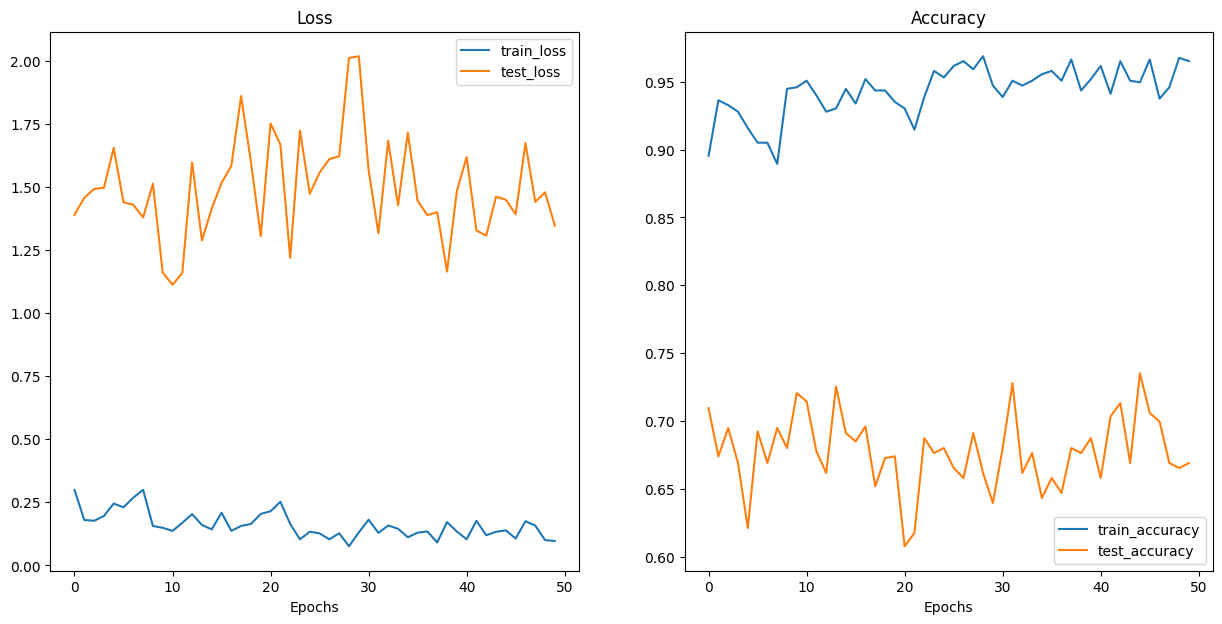

In [ ]:
plot_loss_curves(results)

# MAKE PREDICTIONS ON IMAGES FROM THE TEST SET

In [ ]:
from math import e
def pred_and_plot_image(model, image_path, class_names, image_size, transform, device):
  # Open Image
  img = Image.open(image_path)

  # Create transformation for image (if one doesn't exist)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

    ### Predict on Image ###
    # Make sure the model is on the target device
    model.to(device)

    # Turn on the model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # Transform and add an extra dimension to image
      # (Model requires samples in (batch_size, color_channels, height, width))
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))
    
    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f} | {image_path}")
    plt.axis(False)

In [ ]:
# Get a randome list of image paths from test set
num_images_to_plot = 5
test_image_path_list = list(
    Path(test_dir).glob("*/*.jpg") # get list all image paths from test data
)
test_image_path_sample = random.sample(
    population=test_image_path_list, # Go through all of the test image paths
    k=num_images_to_plot) # randomly select k image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=effi_b0, 
                      image_path=image_path, 
                      class_names=class_names, 
                      # transform=weights.transforms(), # optionally pass in a specified transform of pretrained model
                      transform=None,
                      image_size=(224, 224),
                      device=device
                      )

Output hidden; open in https://colab.research.google.com to view.